# Training on GPU with PyTorch

This notebook is based on the blog article published by Benedict Neo on medium.com n April 2021 :  https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212

This tutorial uses the CIFAR10 dataset which has 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, and ‘truck’.
The 5 steps to build an image classification model
1. Load and normalize the train and test data
1. Define the Convolutional Neural Network (CNN)
1. Define the loss function and optimizer
1. Train the model on the train data
1. Test the model on the test data

Now let’s dive in to the code!

## Requirements

This notebook bas been written using in Python 3.9  kernel on IFB Core cluster environment

Here is the detailed list of Python packages and versions available in this environment : https://gitlab.com/ifb-elixirfr/cluster/tools/-/blob/master/tools/python-pytorch-tensorflow/3.9-1.11.0-2.6.2/env.yml

Please go the [Session information section](#session) to view the final list of python packages and cluster ressources involved in this notebook

Coucou IFB

## Import libraries

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

First, we import the libraries `matplotlib` and `numpy`. These are essential libraries for plotting and data transformation respectively.

The `torch` library is the PyTorch package.
* `torchvision` for loading popular data sets
* `torchvision.transforms` for performing transformation on the image data
* `torch.nn` is for defining the neural network
* `torch.nn.functional` for importing functions like Relu
* `torch.optim` for implementing optimization algorithms such as Stochastic Gradient Descent (SGD)

## 1. Load and normalize data

Before loading our data, we first define a transformation that we want to apply to the image data from the CIFAR10 dataset.

In [4]:
# python image library of range [0, 1] 
# transform them to tensors of normalized range[-1, 1]

transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

# set batch_size
batch_size = 4

# set number of workers
num_workers = 2

# load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Transformation

First, we determine the transformations we want and put it into a list of brackets `[]` and pass it into the `transforms.Compose)` function. In our code, we have these two transformations:

1. `ToTensor()`

    * Converts the type images from the CIFAR10 dataset made up of Python Imaging Library (PIL) images into tensors to be used with with torch library

2. `Normalize(mean, std)`

    * The number of parameters we pass into the mean and std arguments depends on the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) of our PIL image
    * Since our PIL images are RGB, which means they have three channels — red, green, and blue — we pass in 3 parameters for both the mean and standard deviation sequence
    * We pass in 0.5 for `mean` and `std` is because based on the normalization formula : `(x — mean) /std` , the min of our PIL range (0) passed into the formula gives us (0 - 0.5 / 0.5) = -1 and the max (1) gives us (1 - 0.5 / 0.5) = 1 . We end up getting a range of `[-1, 1]`.
    * We normalize to help the CNN perform better as it helps get data within a range and reduces the skewness since it’s centered around 0. This helps it learn faster and better.

### Tuning

Now, let’s move on to the `batch_size` and `num_workers`.

`batch_size`

* This is the number of training samples in one iteration or one forward/backward pass. Since we give `batch_size` the argument 4, this means were are getting 4 images at every iteration of training the network. The first 4 images (1 to 4) are passed into the network, then the next 4 (5–8), and so on until it processes all the samples.
* Splitting our data into batches is crucial because the network is constantly learning and updating its weights. Thus, each batch is training the network successively and considering the updated weights from previous batches.
* There are a few common guidelines to setting the right batch size, but the important thing to remember is that the higher the batch size, the more accurate it is, but at the cost of taking up more memory space.

`num_workers`

* When the value of `num_workers` is set to a positive integer, this allows PyTorch to switch to perform multi-process data loading.
* In our code, we set 2 as the number of workers. This means there are 2 workers simultaneously putting data into the computer’s RAM.
* We use num_workers because it allows us to speed up the training process by utilizing machines with multiple cores. By the time the key process is ready for the next batch of samples, the next batch is already loaded and ready to go.

Now we are ready to define and load our train and test data.

### Loading the test and train data

We use `torchvision.datasets` and call the CIFAR10 data with `.CIFAR10`. Inside this function, we pass in the multiple arguments and set the output to be trainset.

* `root = ’./data’` → this creates a folder named data at the root directory
* `train = True` → we set train as `true` for the train data
* `download = True` → we set download as `true` so we’re downloading the data
* `transform = transform` → we pass in our previously defined transformation to transform the data as it’s loaded in

Then we use `torch.utils.data.DataLoader` to load the data with the arguments below.

* `trainset` → our defined data above
* `batch_size = batch_size` → our `batch_size`
* `shuffle = True` → set to True to have the data reshuffled at every epoch
* `num_workers = num_workers` → 2 workers loading the data

We then set the output to be `trainloader`. We’ll do the same for our test set except we set `train = False` and `shuffle = False` because it’s used to test the network.

After that, we can set define our classes into a `set()` in Python to guarantee that there are no duplicates.

### Visualize images

Next, we visualize some of our training images to get an idea of what we’re using.

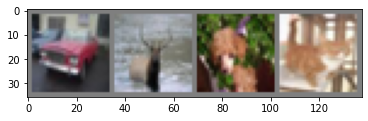

car deer dog cat


In [5]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(trainloader)
images, labels = dataiter.next()

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In our function `imshow`,

* First, we unnormalize our images because they were normalized beforehand. This is just simple math: `y = (x-0.5)/0.5 --> x = (y * 0.5) — 0.5 = (y / 2) + 0.5`.
* Then, we convert them back to numpy objects so we can transpose them with `np.transpose` to get the image in the right shape.
* Last, we call `plt.show` to plot our image

To get a random sample data from our `trainloader` we can use the `iter` function from python, and call `.next()` on it to give us the first output. We set `images, labels =` because the output contains our image data and the labels. This is a concept in tuples if you’re not familiar. It’s the same as doing `a, b = 0, 1`, where `a` is 0 and `b` is 1.

Next, we use the `torchvision.utils.make_grid()` and pass our first batch of images into it, then call `imshow` to plot it out.

You see there are 4 images because our `batch_size` was 4. We can output the classes of our images using a simple generator expression, which basically means we create a `for` loop for `j in range(batch_size)`, where `j` is the `classes[labels[j]]` then since the output is a string, we use `‘%s’` and `join` it using `' '.join()`

## 2. Define the CNN

In [6]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''

    def __init__(self):
        ''' initialize the network '''
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0")
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


It might look very complicated at first glance, but once you understand the important components that make up this network, it can be very intuitive.

We create networks with classes as it gives us an object-oriented approach to building our network. This allows us to tweak every aspect of our network and we can easily visualize the network along with how the forward algorithm works.

First, we initialize our net with Convolutional Layers (conv), pooling, and Fully Connected (fc) layers.

![Convolution Neural Network (CNN)](images/Convolution_Neural_Network.png)

The 3 important elements to understand from the CNN architecture.

### 1. Convolutional Layers (Conv)

![Convolutional Layers (Conv)](images/Convolutional_Layers.png)

* This applies a 2D convolution over an input signal composed of several input planes. In other words, you turn input signals of several channels into feature maps or activation maps.
* arguments: `in_channels`, `out_channels`, `kernel_size`
    * `in_channels = 3` because our image is RGB
    * `out_channels = 6` (read [this post](https://stats.stackexchange.com/a/381032) for guidelines for choosing this number) means the output will have 6 feature maps.
    * `kernel_size = 5` means the size of our square convolutional kernel is 5x5. Kernels are basically filters that act as feature detectors from the original input image. This filter moves around the image, detects the features, and produces the feature maps.
* Notice that our second convolution layer (Conv2) has `in_channels` that has to be the same as the `out_channels` of our first conv (Conv1). This is because input that goes into this network layer is successively, as the output from the first layer is the input for the second layer, and so on.
* Read more about it [here](https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148)

### 2. Max Pooling (MaxPool)

![Max Pooling (MaxPool)](images/Max_Pooling.png)

* The primary purpose of max pooling is to down-sample the dimensions of our image to allow for assumptions to be made about the features in certain regions of the image
* Since we passed in `(2,2)` into `MaxPool2d`, this means we’re turning our image into 2x2 dimensions while retaining "important" features
* Read more [here](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks).

### 3. Fully Connected layers (Fc)

![Fully Connected layers (Fc)](images/Fully_Connected_layers.png)

* Fully connected layers means that every neuron from the previous layers connects to all neurons in the next
* Fully connected layers are the last few layers in the network
* We use the `Linear` transformation in the fc layers, which are the same mathematic operation that happens in Artificial Neural Network.
* The operation follows the form of `g(Wx + b)` where x is our input vectors, W is the weight matrix, b is the bias vector and g is an activation, which is ReLU in our case.
* A good way to think of fc layers is to use the concept of Principal Component Analysis PCA that selects the good features among the feature space created by the Conv and pool layers

In our forward function:

Rectified Linear Unit (ReLU)

![Rectified Linear Unit (ReLU)](images/Rectified_Linear_Unit.png)

We use [ReLU](https://deepai.org/machine-learning-glossary-and-terms/relu) as an activation function in our Conv layers and fc layers. What ReLU accomplishes is essentially it converts the sum of inputs into a single output. If the input is negative then it’s zero, and if it’s positive, it ouputs the input.

The reason why it’s necessary in a CNN is that it introduces non-linearity to our network. Without it, the neural network would just be a single linear function, and it will be hard to handle complicated data (images and audios)

If you want to know more, read [this practical guide to ReLU](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7) by Danqing Liu.

**The Flow of forward algorithm**

Looking at the structure of the function, we can see how everything works successively. First our input (x) passes through the `conv1` object, then it’s passed into a ReLU activation function and then to a max pooling function. Following this idea, we see that the flow is something like below, similar to the image of the CNN architecture given above.

```
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d -> view -> linear -> relu -> linear -> relu -> linear
```

For our forward function, we used the view function, so let’s break down what that does.

`x.view(-1, 16 * 5 * 5)`

* View is used to reshape tensors. With [this example](https://stackoverflow.com/a/42482819) from StackOverflow, let’s say we set `a = torch.range(1, 16)`. `a` is now a tensor with 16 elements. To reshape it, we can use `a.view(4,4)` to turn it into a 4x4 tensor.
* With that, you might ask what `-1` is for. When we don’t know how many rows or columns you want, PyTorch can automatically set a value for you when you pass in `-1`. In our case, we know our columns will be `16 * 5 * 6`, but we don’t know how many rows we want.
* The reason we’re using `view` is that we need to flatten the output from our conv layer and give it to our fully connected layers.
* Another option is to use `x.flatten(1)`, which can be easier to understand.

## 3. Define a Loss function and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Classification Cross Entropy Loss**

`CrossEntropyLoss` from PyTorch is used when training classification problems. What it does is combine log softmax and Negative Log-Likelihood.

Below, I’ll briefly explain the terminologies:

* softmax — scales numbers into probabilities for each outcome. These probabilities sum to 1.
* log softmax — A log version of softmax. It basically applies a log transformation to the probabilities from softmax, which handles numerical unstability. It also allows for improved numerical performance and gradient optimization
* Negative Log-Likelihood — Used in tandem with softmax, negative log-likelihood is a loss function that calculates the loss based on the range of its function. If it receives a small value from the softmax output, it can reach infinite loss which gives us a lower prediction confidence. But if it receives a high value from the softmax output, the loss is smaller, and the confidence is high. See an illustration of this below.

![Classification Cross Entropy Loss](images/Classification_Cross_Entropy_Loss.png)

In basic ANN, the softmax is usually implemented in the neural network itself. But with PyTorch, it has the nifty function `CrossEntropyLoss` which does the job.

**Optimizers**

PyTorch’s `optim` contains a menagerie of optimization algorithms. Using it, we construct an optimizer object that holds the current state of the object, it then updates the parameters based on the computed gradients. This cycle happens until the training ends. It’s basically a fundamental tool for the network to "learn" and update its weights from backpropagation.

A popular alternative for optimizers is Adam. But we’re using Stochastic Gradient Descent which is very common in implementing gradient descent.

Constructing optimizers would first require an iterable containing the parameters to optimize, and then there are other options such as tuning the learning rate and momentum.

What our code means:

* `optim.SGD` → Implements stochastic gradient descent
* `net.parameters()` → gets the learnable parameters of the CNN
* `lr` → learning rate of the gradient descent (how big of a step you take)
* `momentum` → momentum helps accelerate gradient vectors in the right directions, which leads to faster converging.

## 4.Train the network

In [8]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

[1,  2000] loss: 2.255
[1,  4000] loss: 1.885
[1,  6000] loss: 1.687
[1,  8000] loss: 1.567
[1, 10000] loss: 1.521
[1, 12000] loss: 1.466
[2,  2000] loss: 1.385
[2,  4000] loss: 1.350
[2,  6000] loss: 1.346
[2,  8000] loss: 1.315
[2, 10000] loss: 1.302
[2, 12000] loss: 1.271
Finished Training
91467.859375


To time our network training, we can use `torch.cuda.Event` if we are using a GPU powered training since cuda operations are asynchronous.

Let’s break down the training code:

`for epoch in range(2)`

* An epoch is one pass over the entire train set
* This code sets the epoch as 2, which means we loop over the entire train set 2 times
* The number of epochs you choose depends on how long you want to train your network, the right amount depends on the optimizer you use and the network you’re training. We’re going for 2 so it saves time on training.
* Note that too many epochs will lead to overfitting, because the network has been learning from the training data for too long

`for i, data in enumerate(trainloader, 0)`

* Create `for` loop to enumerate over the batches from `trainloader` starting from `index = 0`, where `i` is the batch no. and `data` is a list of `[inputs, labels]`

`inputs, labels = data[0].to(device), data[1].to(device)`

* Split data into inputs and labels objects
* We convert each objects to GPU format using the `.to()` function

`optimizer.zero_grad()`

* Zero the parameter gradients
* It’s a crucial step to zero out the gradients or else all the gradients from multiple passes will accumulated, read more about [why we set gradient to zero](https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)

`outputs = net(inputs)`

* Pass the inputs into our neural network

`loss = criterion(outputs, labels)`

* Criterion is our `CrossEntropyLoss` function, so what we’re doing here is passing our ouputs (a flattened layer of logits) from the network into a log softmax function and negative log likelihood. All this allows us to get the prediction error (loss) of our network.
* Note that outputs is our input (the predicted class), and labels is our target (the correct class).

`loss.backward()`

* `backward` is PyTorch’s way to perform backpropagation by computing the gradient based on the loss.

`optimzer.step()`

* After computing gradient using `backward()`, we can call the optimizer step function, which iterates over all the parameters and update their values.

`running_loss += loss.item()`

* `item()` extracts the loss’s value as a Python float. We then add it to our `running_loss` (which is zero at the start of every iteration)

`if i % 2000 == 1999:`

* Using modulus, we can set the amount of mini-batches we want. Mini batches solves memory constraints as it eliminates the need to calculate the gradient of the entire dataset.
* Since we mod 2000, our mini-batch size is 2000. This is because when is at 1999, 3999, 5999, and so on, modulus of 2000 gives us 1999.

`% (epoch + 1, i + 1, running_loss / 2000))`

* At every iteration of our mini batches, we add one to `i` whenever it finishes 2000 mini-batches. You can observe this at the output where the batch size is increasing 2000 each time.
* Our epoch stays constant until the network finishes seeing the entire dataset
* Our running loss is the average of the mini-batches

`running_loss = 0.0`

* Set running loss as zero again for the next iteration

The differences between mini-batch, batch_size and epoch can be quite confusing. Read more about them [here](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/).

Interpreting our output, we see our loss / predicted error is decreasing, and it took roughly 2.3 minutes to train.

### Saving neural networks

A good tip is to save the neural networks to save time. Here’s how to do it.

In [9]:
# save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
# reload
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 5. Test the network on test data

With our model trained and ready to go, let’s now test it on a single batch by calling the iter function on our `testloader` and get our images and labels using the next function.

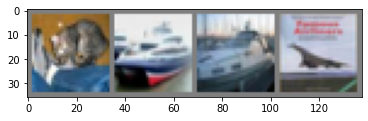

GroundTruth:  cat ship ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

We see that the model correctly labelled the images and they represent what our human eyes can see!

In [11]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  cat ship ship ship


We can use our trained network by calling `net()` on our images.

`_, predicted = torch.max(outputs, 1)`

* What `torch.max` does is it returns the maximum values of all the elements in the output tensor. The argument dim which we set to 1 stands for which axis we want to find the max value. The output of this command gives us the index and the actual elements in the tensor.
* We set `dim = 1` because our predictions are in rows of the tensor, and we want the max for each rows. We don’t need the actual values of the output, only the index, so we can use `_` in Python to set it as an unnecessary variable. Taking the index our maximum, we can take it and find the label of the class based on the class set we defined previously.

### Testing on 10,000 images

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


`torch.no_grad()`

* `torch.no_grad` is used when we don’t require PyTorch to run its autograd engine, in other words, calculate the gradients of our input. Since we’re only calculating the accuracy of our network. This will help reduce memory usage and speed up computation.

`(predicted == labels).sum().item()`

* this is a boolean expression. We can sum the amount of times we get the right prediction, and then grab the numeric value using `item()`

## Session information
<a id='session'></a>

### Python session information

In [13]:
%reload_ext watermark
%watermark -a "Julien Seiler" -e "seilerj@igbmc.fr" -i -u -v -iv

Author: Julien Seiler

Email: seilerj@igbmc.fr

Last updated: 2022-06-14T14:12:18.471051+02:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

numpy      : 1.22.4
torchvision: 0.12.0
matplotlib : 3.5.2
torch      : 1.11.0



In [14]:
!pip install session_info
import session_info
session_info.show(html=False)

Defaulting to user installation because normal site-packages is not writeable
-----
matplotlib          3.5.2
numpy               1.22.4
session_info        1.0.0
torch               1.11.0
torchvision         0.12.0
-----
IPython             8.4.0
jupyter_client      7.3.1
jupyter_core        4.10.0
notebook            6.4.11
-----
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21) [GCC 10.3.0]
Linux-3.10.0-1160.6.1.el7.x86_64-x86_64-with-glibc2.17
-----
Session information updated at 2022-06-14 14:12


### Cluster reservation information

In [ ]:
!scontrol show job $SLURM_JOB_ID

### Ressource usage

In [15]:
!sstat --jobs=$SLURM_JOB_ID --format=MaxRSS,AveCPU

    MaxRSS     AveCPU 
---------- ---------- 
 11833620K  14:41.000 
